In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import vcf
from germline_cnv_evaluation import GenericCNVCallSet, GenericCopyNumberVariant
from germline_cnv_evaluation import load_gcnv_segments_vcf_file
from intervaltree_bio import GenomeIntervalTree, IntervalTree
import pandas as pd

/home/slee/.pyenv/versions/anaconda3-4.3.1/envs/gatk-dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import logging

_logger = logging.getLogger(__name__)
log_frequency = 500

In [4]:
chm_truth_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/CHM1_CHM13_SVs.annotated.vcf'
hg00514_truth_bed_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/ILL_PB_RO.5.HG00514.bed'
hg00733_truth_bed_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/ILL_PB_RO.5.HG00733.bed'
na19240_truth_bed_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/ILL_PB_RO.5.NA19240.bed'

In [5]:
chm_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/genotyped-segments-G94794.CHMI_CHMI3_WGS1.cram.vcf'
hg00514_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/genotyped-segments-HG00514_1.cram.samtools.vcf'
hg00733_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/genotyped-segments-HG00733_1.cram.samtools.vcf'
na19240_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/genotyped-segments-NA19240.samtools.vcf'

In [6]:
interval_list_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/hg38.wgs.1.2.3.intervals.preprocessed.interval_list'

In [7]:
# def generate_truth_set(chm_truth_vcf_file):
#     with open(chm_truth_vcf_file, 'r') as f:
#         vcf_reader = vcf.Reader(f)
#         sample_names = vcf_reader.samples
#         chm_call_set = GenericCNVCallSet('CHM1')

#         for record_num, record in enumerate(vcf_reader):

#             if record_num % log_frequency == 0:
#                 _logger.info("Reading record number {0}...".format(record_num))

#             info = record.INFO
#             contig = record.CHROM
#             start = record.start + 1
#             end = info['END']

#             for si, sample_record in enumerate(record.samples):
#                 contig_support = sample_record.data.CONTIG_SUPPORT

#                 # generate variant
#                 sample_var = GenericCopyNumberVariant(contig, start, end, sample_record.data.CN, quality,
#                                                       variant_frequency=variant_frequency,
#                                                       variant_class=None,
#                                                       genotype=None)
#                 chm_call_set.add(sample_var)
    
#     return chm_call_set_list

In [8]:
# chm_call_set = generate_truth_set(chm_truth_vcf_file)

In [9]:
def generate_truth_call_set_and_caller_map_from_bed(truth_bed_file, sample_name):
    truth_bed_pd = pd.read_csv(truth_bed_file, sep='\t', header=None)
    call_set = GenericCNVCallSet(sample_name)
    caller_map = {}
    for record in truth_bed_pd.values:
        contig = record[0]
        start = int(record[1]) + 1
        end = int(record[2])
        sv_type = record[3]
        if sv_type == 'DEL':
            var_copy_number = -1
            genotype = 'del'
        elif sv_type == 'CNV':
            var_copy_number = -1
            genotype = 'cnv'
        else:
            continue
        quality = 99
        var = GenericCopyNumberVariant(contig, start, end, var_copy_number, quality, genotype=genotype)
        callers = record[4].split(',')
        call_set.add(var)
        caller_map[var] = callers
    
    return call_set, caller_map

In [10]:
def generate_call_set_from_gcnv_vcf(gcnv_vcf_file):
    allele_to_genotype_map = {'N': 'ref', '<DEL>': 'del', '<DUP>': 'dup'}
    quality_mode: str = "some"
    with open(gcnv_vcf_file, 'r') as f:
        vcf_reader = vcf.Reader(f)
        sample_name = vcf_reader.samples[0]
        gcnv_call_set = GenericCNVCallSet(sample_name)

        for record_num, record in enumerate(vcf_reader):

            if record_num % log_frequency == 0:
                _logger.info("Reading record number {0}...".format(record_num))

            info = record.INFO
            contig = record.CHROM
            start = record.start + 1
            end = info['END']

            info = record.INFO
            contig = record.CHROM
            start = record.start + 1
            end = info['END']
            var_copy_number = record.samples[0]['CN']
            genotype_index = int(record.samples[0]['GT'])
            allele = str(record.alleles[genotype_index])
            num_intervals = record.samples[0]['NP']
            genotype = allele_to_genotype_map[allele]

            if quality_mode == "some":
                quality = num_intervals * record.samples[0]["QS"]
            elif quality_mode == "all":
                quality = record.samples[0]["QA"]
            else:
                raise Exception("Unknown quality calculation mode -- valid options are \"some\" and \"all\"")

            # generate variant
            if genotype != 'ref':
                sample_var = GenericCopyNumberVariant(contig, start, end, var_copy_number, quality,
                                                      genotype=genotype,
                                                      num_intervals=num_intervals,
                                                      variant_frequency=None,
                                                      variant_class=None)
                gcnv_call_set.add(sample_var)
    
    return gcnv_call_set

In [36]:
hg00514_tuple = (hg00514_truth_bed_file, 'HG00514_1', hg00514_gcnv_vcf_file)
hg00733_tuple = (hg00733_truth_bed_file, 'HG00733_1', hg00733_gcnv_vcf_file)
na19240_tuple = (na19240_truth_bed_file, 'NA19240', na19240_gcnv_vcf_file)

In [45]:
from collections import Counter, defaultdict

min_overlap_fraction = 0.5

min_truth_lengths = [0, 250, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

sensitivity_curves = defaultdict(list)

for min_truth_length in min_truth_lengths:
    num_TP = 0
    num_FN = 0
    num_miss = 0
    num_wrong = 0
    num_TP_callers = Counter()
    for truth_bed_file, sample_name, gcnv_vcf_file in [hg00514_tuple, hg00733_tuple, na19240_tuple]:
        truth_call_set, truth_caller_map = generate_truth_call_set_and_caller_map_from_bed(truth_bed_file, sample_name)
        gcnv_call_set = generate_call_set_from_gcnv_vcf(gcnv_vcf_file)

        for contig in gcnv_call_set.contig_set:
            for var in truth_call_set.iter_in_contig(contig):
                if var.length_gte_value(min_truth_length):# and var.genotype == 'del':
                    for caller in truth_caller_map[var]:
                        num_TP_callers[caller] += 1
                    overlapping_vars = gcnv_call_set.get_overlapping_variants_set(var, 'other', min_overlap_fraction=min_overlap_fraction)
                    if len(overlapping_vars) == 0:
                        num_miss += 1
                        num_FN += 1
                        continue

                    for overlapping_var, _ in overlapping_vars:
                        if not ((var.genotype == 'del' and overlapping_var.genotype == 'del') or 
                                (var.genotype == 'cnv' and (overlapping_var.genotype == 'del' or overlapping_var.genotype == 'dup'))):
                            num_wrong += 1
                            num_FN += 1
                            break
                    else:
                        num_TP += 1

    print(min_truth_length, num_TP, num_FN, num_miss, num_wrong, num_TP / (num_TP + num_FN))
    sensitivity_curves['GATK gCNV'].append((min_truth_length, num_TP / (num_TP + num_FN)))
    for caller in ['dCGH', 'Delly', 'ForestSV', 'liWGS', 'lumpy', 'Manta', 'MELT', 'novoBreak', 
                   'Pindel', 'SVelter', 'VH', 'wham', 'GenomeStrip']:
        if caller == 'GenomeStrip':
            sensitivity_curves['GenomeSTRiP'].append((min_truth_length, num_TP_callers[caller] / (num_TP + num_FN)))
        else:
            sensitivity_curves[caller].append((min_truth_length, num_TP_callers[caller] / (num_TP + num_FN)))

0 1557 11853 11805 48 0.11610738255033556
250 1539 5261 5222 39 0.2263235294117647
500 1455 1511 1478 33 0.49055967633175995
1000 1224 904 885 19 0.575187969924812
2000 868 509 496 13 0.6303558460421206
3000 634 309 305 4 0.672322375397667
4000 510 240 238 2 0.68
5000 396 207 205 2 0.6567164179104478
6000 314 171 170 1 0.6474226804123712
7000 204 107 106 1 0.6559485530546624
8000 145 73 72 1 0.6651376146788991
9000 113 62 61 1 0.6457142857142857
10000 88 55 54 1 0.6153846153846154


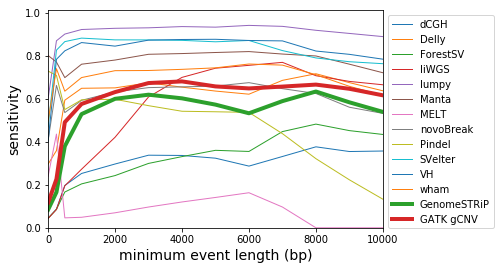

In [47]:
for caller in ['dCGH', 'Delly', 'ForestSV', 'liWGS', 'lumpy', 'Manta', 'MELT', 'novoBreak', 'Pindel', 'SVelter', 'VH', 'wham',
               'GenomeSTRiP', 'GATK gCNV']:
    sensitivity_curve = sensitivity_curves[caller]
    min_truth_lengths, sensitivity = zip(*sensitivity_curve)
    xlim([0, max(min_truth_lengths)])
    ylim([0, 1.01])
    plot(min_truth_lengths, sensitivity, label=caller, lw=4 if caller == 'GATK gCNV' or caller == 'GenomeSTRiP' else 1)
xlabel('minimum event length (bp)', fontsize=14)
ylabel('sensitivity', fontsize=14)
# title('HG00514_1', fontsize=16)
legend(bbox_to_anchor=(1, 1))
show()